In [5]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
#%matplotlib widget

import os
import tempfile

## Dumped Harmonic Oscillator RNN model
In this notebook, we will train a rNN with the loss function given by the MSE on the train points. The architecture, number of data point, epochs and hyperparamenters, all shared with the ../models/PINN_baseline_model.pt, will be the baseline for further improvements.

In [147]:
import torch
# Number of epochs
n_epochs = 25000

# Learning rate and scheduler
lr = 0.01
factor = 0.85 #
patience = 200 #

# Assumed values for the example
n_layers = 3 # Number of LSTM layers
n_neurons = 20 # Number of neurons in each LSTM layer
input_size = 1 # The input feature size, here it's 1 because we only input time
seq_len = 25 #50 # Sequence lenghts
batch_size = batch_size = 600 #250 # Batch size

# Model class
class RNN_net(torch.nn.Module):
    def __init__(self, n_layers, n_neurons, input_size):
        super(RNN_net, self).__init__()
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Initializing the LSTM layer
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=n_neurons, num_layers=n_layers, batch_first=True)
        
        # Fully connected layer that outputs two values: position and velocity
        self.fc = torch.nn.Linear(n_neurons, 2)

    def forward(self, x):
        # Initialise hidden state and cell state with dimensions (num_layers, batch_size, n_neurons)
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers, batch_size, self.n_neurons).to(x.device)
        c0 = torch.zeros(self.n_layers, batch_size, self.n_neurons).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Reshape output from (batch_size, seq_len, n_neurons) to (batch_size * seq_len, n_neurons)
        out = out.contiguous().view(-1, self.n_neurons)
        # Forward pass through the fully connected layer.
        out = self.fc(out)
        # Reshape back to (batch_size, seq_len, 2)
        out = out.view(batch_size, -1, 2)
        return out




The RNN_net model is designed to process sequential data and make predictions about the position and velocity of the data points. It accomplishes this by utilizing a recurrent neural network (RNN) architecture, specifically the Long Short-Term Memory (LSTM) layer.

The model takes as input three parameters: the number of layers (n_layers), the number of neurons in each layer (n_neurons), and the input size (input_size). These parameters are used to initialize the LSTM layer and the fully connected layer (fc).

During the forward pass, the input tensor x is fed into the LSTM layer. The LSTM layer makes use of hidden and cell state tensors to capture the temporal dependencies in the sequential data. These hidden and cell states are initialized based on the device of the input tensor.

The output of the LSTM layer is reshaped into a 2D tensor to match the input shape of the fully connected layer. This allows the fully connected layer to process the output of the LSTM layer and generate predictions. The fully connected layer maps the hidden representations from the LSTM layer to two output values: position and velocity.

The final step involves reshaping the output tensor back into its original shape, representing predictions for each input data point.

## Load data

In [148]:

# import data
data = np.load('../data/DHOscillator_data.npy')
X = data[:,0]
Y = data[:,1:]

print(np.shape(X))
print(np.shape(Y))


(1000,)
(1000, 2)


Here's a step-by-step breakdown and code to prepare the data:

Normalize or preprocess the data if necessary.
Split the data into training, validation, and testing sets.
Create input sequences (X_batch) and corresponding outputs (Y_batch) for each set.
Convert the data into PyTorch tensors and create DataLoader instances for batch processing.


In [149]:

import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_sequences(X, Y, seq_len):
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_len + 1):   
        X_seq.append(X[i:i+seq_len])
        Y_seq.append(Y[i:i+seq_len])    
    
    return np.array(X_seq), np.array(Y_seq)

total_time = 30
cutoff_time = 0.85 * total_time  
cutoff_index = np.argmax(X >= cutoff_time)  


X_train_val = X[:cutoff_index]  
Y_train_val = Y[:cutoff_index]  
X_test = X[cutoff_index:]  
Y_test = Y[cutoff_index:]  

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)  


# Creating sequences
X_train_seq, Y_train_seq = create_sequences(X_train, Y_train, seq_len)
X_val_seq, Y_val_seq = create_sequences(X_val, Y_val, seq_len)
X_test_seq, Y_test_seq = create_sequences(X_test, Y_test, seq_len)

# Converting numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_seq.astype(np.float32)).unsqueeze(-1)
Y_train_tensor = torch.from_numpy(Y_train_seq.astype(np.float32))
X_val_tensor = torch.from_numpy(X_val_seq.astype(np.float32)).unsqueeze(-1)
Y_val_tensor = torch.from_numpy(Y_val_seq.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_seq.astype(np.float32)).unsqueeze(-1)
Y_test_tensor = torch.from_numpy(Y_test_seq.astype(np.float32))

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


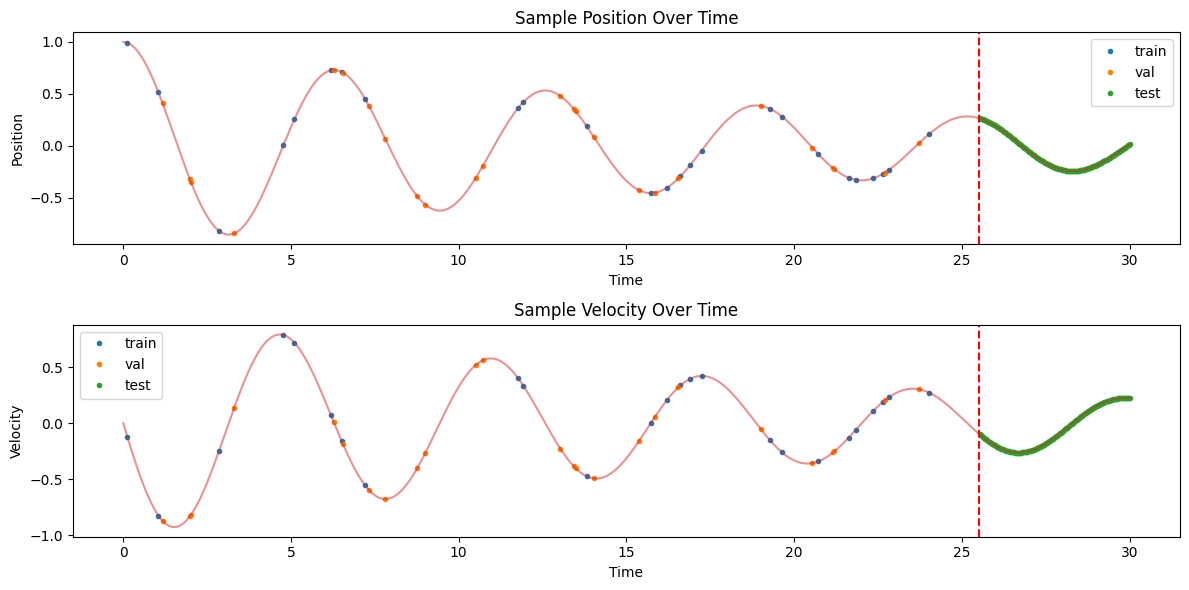

In [150]:
import matplotlib.pyplot as plt

# Extracting one batch of training data
X_train_batch, Y_train_batch = next(iter(train_loader))
X_train_batch_np = X_train_batch.detach().numpy()
Y_train_batch_np = Y_train_batch.detach().numpy()

X_val_batch, Y_val_batch = next(iter(val_loader))
X_val_batch_np = X_val_batch.detach().numpy()
Y_val_batch_np = Y_val_batch.detach().numpy()

X_test_batch, Y_test_batch = next(iter(test_loader))
X_test_batch_np = X_test_batch.detach().numpy()
Y_test_batch_np = Y_test_batch.detach().numpy()

sample_idx = 0

X_train_sample = X_train_batch_np[sample_idx,:,0]
Y_train_sample_position = Y_train_batch_np[sample_idx,:,0]
Y_train_sample_velocity = Y_train_batch_np[sample_idx,:,1]
X_val_sample = X_val_batch_np[sample_idx,:,0]
Y_val_sample_position = Y_val_batch_np[sample_idx,:,0]
Y_val_sample_velocity = Y_val_batch_np[sample_idx,:,1]
#X_test_sample = X_test_batch_np[:,:,0]
#Y_test_sample_position = Y_test_batch_np[:,:,0]
#Y_test_sample_velocity = Y_test_batch_np[:,:,1]

plt.figure(figsize=(12, 6))

# Position vs Time
plt.subplot(2, 1, 1)
plt.plot(X_train_sample, Y_train_sample_position, '.',label="train")
plt.plot(X_val_sample, Y_val_sample_position, '.',label="val")
plt.plot(X_test, Y_test[:,0], '.', label="test")  
plt.plot(X,Y[:,0],alpha=0.5)
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Sample Position Over Time")
plt.legend()

# Velocity vs Time
plt.subplot(2, 1, 2)
plt.plot(X_train_sample, Y_train_sample_velocity, '.',label="train")
plt.plot(X_val_sample, Y_val_sample_velocity, '.',label="val")
plt.plot(X_test, Y_test[:,1], '.', label="test")  
plt.plot(X,Y[:,1],alpha=0.5)
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Sample Velocity Over Time")
plt.legend()

plt.tight_layout()
plt.show()



## RNN

The RNN will be trained on data point with time < 25, discarding validation data this means 595 point of the ODE.

In [151]:
train_hist = []
lr_hist = [] 

# defining the model, loss function, optimizer, and lr scheduler (same as before)
model = RNN_net(n_layers, n_neurons,input_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience)

# Moving to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Function to calculate the loss and learning rate value
def evaluate_model(model, val_loader, criterion, optimizer):
    model.eval()  # Set to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No gradient calculation
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()
            
    # Save the learning rate value
    lr_value = optimizer.param_groups[0]['lr']
    return val_loss / len(val_loader), lr_value

# Training loop
for epoch in range(n_epochs):
    model.train()  # Set to training mode
    train_loss = 0
    
    for X_batch, Y_batch in train_loader:
        # Move batch to device
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(X_batch)
        # Loss calculation
        loss = loss_fn(outputs, Y_batch)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    train_hist.append(train_loss)  
    val_loss, lr_value = evaluate_model(model, val_loader, loss_fn, optimizer)
    lr_hist.append(lr_value)  
    scheduler.step(val_loss)  # adjust lr based on validation loss
       
    # Log the training progress
    print(f'Epoch: {epoch+1}/{n_epochs}, Training Loss: {train_loss:.6f}, lr : {lr_value:.6f}')

torch.save(model.state_dict(), '../models/DHOscillator_RNN.pt')
history = {'train_loss': train_hist, 'lr': lr_hist}
np.save('../history/RNN_history.npy', history)


Epoch: 1/25000, Training Loss: 0.183842, lr : 0.010000
Epoch: 2/25000, Training Loss: 0.195565, lr : 0.010000
Epoch: 3/25000, Training Loss: 0.185431, lr : 0.010000
Epoch: 4/25000, Training Loss: 0.183849, lr : 0.010000
Epoch: 5/25000, Training Loss: 0.186558, lr : 0.010000
Epoch: 6/25000, Training Loss: 0.184635, lr : 0.010000
Epoch: 7/25000, Training Loss: 0.178148, lr : 0.010000
Epoch: 8/25000, Training Loss: 0.182552, lr : 0.010000
Epoch: 9/25000, Training Loss: 0.172879, lr : 0.010000
Epoch: 10/25000, Training Loss: 0.185512, lr : 0.010000
Epoch: 11/25000, Training Loss: 0.182288, lr : 0.010000
Epoch: 12/25000, Training Loss: 0.175373, lr : 0.010000
Epoch: 13/25000, Training Loss: 0.185222, lr : 0.010000
Epoch: 14/25000, Training Loss: 0.173410, lr : 0.010000
Epoch: 15/25000, Training Loss: 0.182905, lr : 0.010000
Epoch: 16/25000, Training Loss: 0.173769, lr : 0.010000
Epoch: 17/25000, Training Loss: 0.181595, lr : 0.010000
Epoch: 18/25000, Training Loss: 0.171743, lr : 0.010000
E

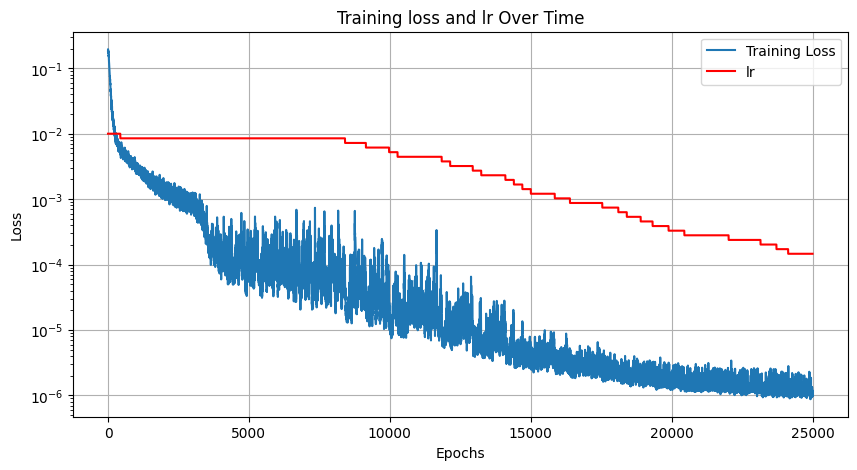

In [154]:
import matplotlib.pyplot as plt
# Load the training history
history = np.load('../history/RNN_history.npy', allow_pickle=True).item()

# Create a figure
plt.figure(figsize=(10, 5))

# Plot the training loss
plt.semilogy(history['train_loss'], label='Training Loss')

# Plot the validation loss
plt.semilogy(history['lr'], label='lr',color = 'r')

# Additional plot settings
plt.title('Training loss and lr Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the figure
plt.show()


In [167]:
model = RNN_net(n_layers, n_neurons,input_size)
model.load_state_dict(torch.load('../models/DHOscillator_RNN.pt'))
model.eval()

# Get predictions from the model
Y_train_pred = model(X_train_batch)
Y_test_pred = model(X_test_batch)

# Extract the position and velocity from predictions
# Now we will use the last step in the sequence for each sample for plotting
Y_train_pred_position = Y_train_pred[:, -1, 0].detach().numpy()
Y_train_pred_velocity = Y_train_pred[:, -1, 1].detach().numpy()
Y_test_pred_position = Y_test_pred[:, 0, 0].detach().numpy()
Y_test_pred_velocity = Y_test_pred[:, 0, 1].detach().numpy()



# Time axis for the last step of each sequence
X_train_batch_np = X_train_batch.detach().numpy()
time_steps_train = X_train_batch_np[:, -1 , 0]
X_test_batch_np = X_test_batch.detach().numpy()
time_steps_test = X_test_batch_np[:, 0, 0]

print(Y_train_pred_position.shape)


(600,)


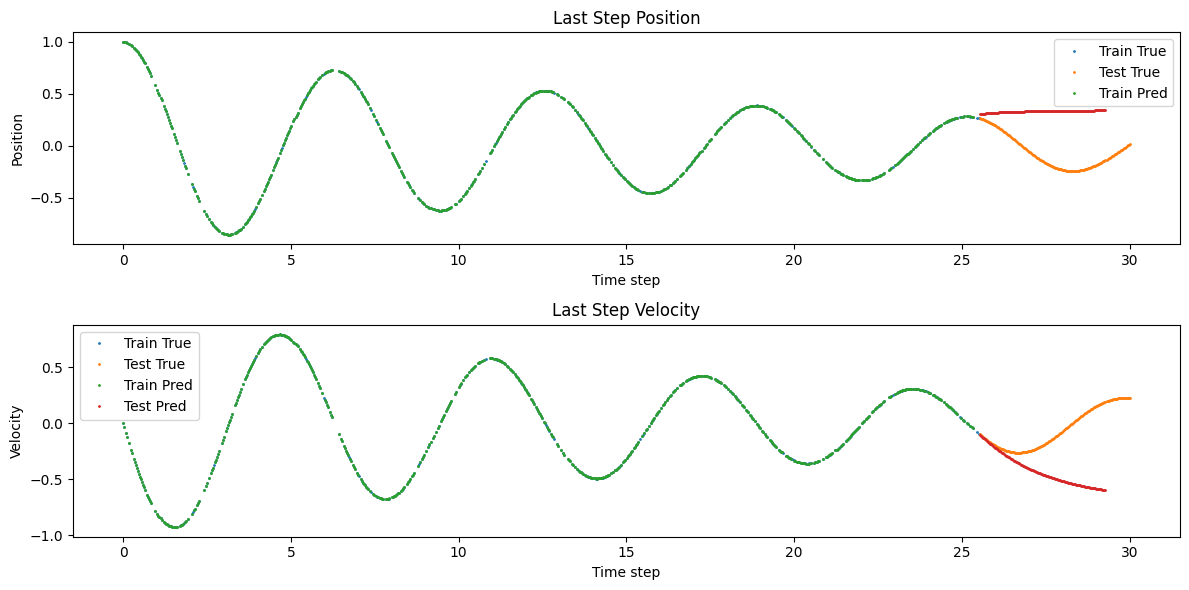

In [168]:

# Now we have the predictions and can plot them alongside the true values
plt.figure(figsize=(12, 6))

# Position vs Time
plt.subplot(2, 1, 1)
plt.plot(X_train, Y_train[:, 0],'.',markersize = 2, label="Train True")
plt.plot(X_test, Y_test[:,0],'.',markersize = 2,   label="Test True")
plt.plot(time_steps_train, Y_train_pred_position,'.',markersize = 2,  label="Train Pred")
plt.plot(time_steps_test, Y_test_pred_position,'.', markersize = 2)#, label="Test Pred")
plt.xlabel("Time step")
plt.ylabel("Position")
plt.title("Last Step Position")
plt.legend()

# Velocity vs Time
plt.subplot(2, 1, 2)
plt.plot(X_train, Y_train[:, 1],'.',markersize = 2,  label="Train True")
plt.plot(X_test, Y_test[:, 1],'.', markersize = 2, label="Test True")
plt.plot(time_steps_train, Y_train_pred_velocity,'.', markersize = 2,  label="Train Pred")
plt.plot(time_steps_test, Y_test_pred_velocity,'.', markersize = 2,  label="Test Pred")
plt.xlabel("Time step")
plt.ylabel("Velocity")
plt.title("Last Step Velocity")
plt.legend()

plt.tight_layout()
plt.show()